# Blobs classification 3

Changes:
* Added regularizations:
** Dropout
** L2

Tested:
* Different learning rates and different optimizers, SGD required extensive tweeking of the learning rate to accomodate the L2 regularization (worked with lr = 0.3). Adam instead worked well already with lr = 0.2

In [3]:
import torch
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Graphics settings
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['axes.grid'] = False
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelcolor'] = 'grey'
mpl.rcParams['font.size'] = 15
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['text.color'] = 'grey'
mpl.rcParams['xtick.minor.visible'] = False
mpl.rcParams['ytick.minor.visible'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.loc'] = 'upper left'
mpl.rcParams['figure.constrained_layout.h_pad'] = 0.12
mpl.rcParams['figure.constrained_layout.w_pad'] = 0.12
mpl.rcParams['figure.max_open_warning'] = 200

### Device / dtypes settings

In [158]:
params = {}

if torch.cuda.is_available():
    params['device'] = torch.device('cuda', 0)
else:
    params['device'] = torch.device('cpu')

params['dtypes'] = {'X': np.float32, 'y': np.int64}

params['n_epochs'] = 20

params['train_batch_size'] = 50

params['n_hidden_layers'] = 20
params['hidden_layers_size'] = 20

params['learning_rate'] = 1e-2

#regularization
params['dropout_p'] = 0.2
params['l2_lambda'] = 1e-6

params

{'device': device(type='cuda', index=0),
 'dtypes': {'X': numpy.float32, 'y': numpy.int64},
 'n_epochs': 20,
 'train_batch_size': 50,
 'n_hidden_layers': 20,
 'hidden_layers_size': 20,
 'learning_rate': 0.01,
 'dropout_p': 0.2,
 'l2_lambda': 1e-06}

## Dataset

In [5]:
def generate_dataset() -> None:
    import sklearn.datasets
    import sklearn.model_selection
    
    X, y = sklearn.datasets.make_blobs(
        n_samples=20_000,
        centers=6,
        cluster_std=1.1,
        random_state=0
    )

    # generate a downsampling mask for each class to a given amount
    y_probs = y.copy().astype('f4')
    y_probs[y_probs == 0] = 0.99
    y_probs[y_probs == 1] = 0.1
    y_probs[y_probs == 2] = 0.5
    y_probs[y_probs == 3] = 0.4
    y_probs[y_probs == 4] = 0.9
    y_probs[y_probs == 5] = 0.2

    mask = (
        torch.bernoulli(
            torch.from_numpy(y_probs)
            .to(torch.float32))
        .to(torch.bool)
        .numpy()
    )

    # merge some classes
    #y[y == 3] = 1
    y[y == 2] = 5
    y[y == 4] = 0

    # downsample
    X = X[mask, :]
    y = y[mask]

    
    # split to train and test
    (
        X_train, 
        X_test, 
        y_train, 
        y_test
    ) = sklearn.model_selection.train_test_split(
        X, 
        y, 
        train_size = 0.6
    )
    
    return (
        X_train, 
        X_test, 
        y_train, 
        y_test
    )
    
(
    X_train, 
    X_test, 
    y_train, 
    y_test
) = generate_dataset()

In [6]:
X_train[:10, :], y_train[:10], np.unique(y_train, return_counts=True)

(array([[-2.31602311,  3.70669721],
        [ 1.22294752,  2.45723013],
        [-0.68619493,  1.2803728 ],
        [-2.25615481,  6.80338483],
        [ 8.18624726, -1.53049507],
        [ 1.45963963,  1.30541322],
        [ 1.92255887,  7.86659203],
        [ 9.54282729, -3.32354952],
        [ 9.89306239, -1.81974586],
        [ 9.90023892, -1.70643517]]),
 array([5, 0, 5, 3, 0, 1, 3, 0, 0, 0]),
 (array([0, 1, 3, 5]), array([3868,  194,  741, 1327])))

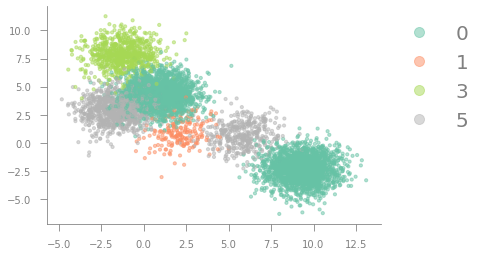

In [7]:
fig = plt.figure(1)
ax = fig.add_subplot()
pl1 = ax.scatter(*X_train.T, c=y_train, cmap='Set2', s=10, alpha = 0.5)
_ = ax.legend(
    *pl1.legend_elements(prop='colors', size=10),
    bbox_to_anchor=(1,1),
    fontsize=20
)   


## Setup the transformers

In [8]:

# the ordinal encoder must be fit and used to transform with a 2 d array (dim 0 being the observations)
y_ordinal_encoder = (
    sklearn
    .preprocessing
    .OrdinalEncoder()
    .fit(y_train[:, None])
)

X_standard_scaler = (
    sklearn
    .preprocessing
    .StandardScaler()
    .fit(X_train)
)

In [9]:
y_ordinal_encoder.transform(y_train[:, None]).squeeze() # need to add a dimension to fit, after that it has to be removed (squeezed)

array([3., 0., 3., ..., 2., 0., 0.])

In [10]:
X_standard_scaler.transform(X_train)

array([[-1.20440519,  0.41908854],
       [-0.42265458,  0.07198935],
       [-0.84437983, -0.25493901],
       ...,
       [-1.18003123,  1.79383094],
       [ 1.6102842 , -1.09592858],
       [-0.76810505,  1.03916911]])

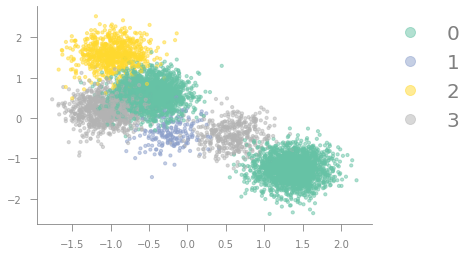

In [11]:
fig = plt.figure(1)
ax = fig.add_subplot()
pl1 = ax.scatter(
    *X_standard_scaler.transform(X_train).T,
    c=y_ordinal_encoder.transform(y_train[:, None]).squeeze(), 
    cmap='Set2', s=10, alpha = 0.5
)
_ = ax.legend(
    *pl1.legend_elements(prop='colors', size=10),
    bbox_to_anchor=(1,1),
    fontsize=20
)   


## Setup the dataset

In [12]:
class Dataset_(torch.utils.data.Dataset):
    def __init__(self, 
                 X, 
                 y, 
                 X_transformer = None, 
                 y_transformer = None, 
                 X_dtype = np.float32,
                 y_dtype = np.int64):
        
        import numpy as np
        self.X = X
        self.y = y
        self.X_transformer = X_transformer
        self.y_transformer = y_transformer
        self.n_items = X.shape[0]
        self.X_dtype = X_dtype
        self.y_dtype = y_dtype
        
        # setup the weights
        weights = y.copy().astype(np.float32) # has to be float because later weights (float) will be inserted here
        levels, counts = np.unique(y, return_counts = True)
        n_levels = len(levels)
        self.balanced_dataset_size = int(np.min(counts) * n_levels)
        average_weight = 1 / n_levels
        
        # assign to each class a weight (lower representec classes have larger weights)
        level_weights = {}
        for level in levels:
            n_level = np.sum(y == level)
            level_proportion = n_level / self.n_items
            if y_transformer is not None:
                level = np.array([[level]])
                level = y_transformer.transform(level)
                level = int(level.squeeze())
            level_weights[level] = average_weight / level_proportion
            
        self.level_weights = level_weights
        self.n_levels = n_levels
        
    def __getitem__(self, index):
        # deal with transformations if specified
        if self.X_transformer is not None:
            X = self.X[[index], :] # must be 2d [[1, 3]]
            X = self.X_transformer.transform(X)
            X = np.squeeze(X)
        else:
            X = self.X[index]
        if self.y_transformer is not None:
            y = np.array([[self.y[index]]]) # must be 2d [[0]]
            y = self.y_transformer.transform(y)
            y = np.squeeze(y)
        else:
            y = self.y[index]
            
        return X.astype(self.X_dtype), y.astype(self.y_dtype)
    
    def __len__(self):
        return self.n_items

In [13]:
train_dataset = Dataset_(
    X_train, 
    y_train, 
    X_standard_scaler, 
    y_ordinal_encoder,
    X_dtype = params['dtypes']['X'],
    y_dtype = params['dtypes']['y']
)

train_dataset[0]

(array([-1.2044052 ,  0.41908854], dtype=float32), array(3))

In [14]:
test_dataset = Dataset_(
    X_test, 
    y_test, 
    X_standard_scaler, 
    y_ordinal_encoder,
    X_dtype = params['dtypes']['X'],
    y_dtype = params['dtypes']['y']
)

test_dataset[0]

(array([-1.085259 ,  1.3576102], dtype=float32), array(2))

In [15]:
train_dataset.level_weights

{0: 0.39619958634953467,
 1: 7.8994845360824755,
 2: 2.0681511470985154,
 3: 1.154860587792012}

In [16]:
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset, 
    batch_size = params['train_batch_size'] , 
    pin_memory = True
)

In [17]:
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset, 
    batch_size=len(test_dataset), 
    pin_memory = True,
    #pin_memory_device=''
)

In [18]:
for i, (X_train_batch, y_train_batch) in enumerate(train_dataloader):
    if i < 4:
        print(
            f'X -> \n{X_train_batch[:10]}\n'
            f'{X_train_batch.device}\n'
            f'y -> \n{y_train_batch[:10]}\n'
            f'labels, label counts -> \n{np.unique(y_train_batch, return_counts = True)}\n\n'
        )

X -> 
tensor([[-1.2044,  0.4191],
        [-0.4227,  0.0720],
        [-0.8444, -0.2549],
        [-1.1912,  1.2793],
        [ 1.1155, -1.0358],
        [-0.3704, -0.2480],
        [-0.2681,  1.5747],
        [ 1.4152, -1.5339],
        [ 1.4926, -1.1161],
        [ 1.4941, -1.0847]])
cpu
y -> 
tensor([3, 0, 3, 2, 0, 1, 2, 0, 0, 0])
labels, label counts -> 
(array([0, 1, 2, 3]), array([30,  3,  8,  9]))


X -> 
tensor([[-1.3323,  0.0602],
        [-0.6367,  0.3732],
        [-1.0054, -0.4094],
        [ 1.4412, -1.1719],
        [-0.4812,  0.6280],
        [-0.0148, -0.6329],
        [-0.4720,  0.6153],
        [-1.3106,  0.1991],
        [ 1.4663, -1.5447],
        [ 1.8527, -0.8169]])
cpu
y -> 
tensor([3, 0, 3, 0, 0, 1, 0, 3, 0, 0])
labels, label counts -> 
(array([0, 1, 2, 3]), array([34,  1,  6,  9]))


X -> 
tensor([[ 0.3839, -0.6729],
        [-0.7173,  1.0399],
        [ 1.1484, -1.1104],
        [-0.4102,  0.3685],
        [ 0.8178, -0.6889],
        [ 0.7453, -1.4871],
      

In [19]:
for i, (X_test_batch, y_test_batch) in enumerate(test_dataloader):
    if i < 4:
        print(
            f'X -> \n{X_test_batch[:10]}\n'
            f'{X_test_batch.device}\n'
            f'y -> \n{y_test_batch[:10]}\n'
            f'labels, label counts -> \n{np.unique(y_test_batch, return_counts = True)}\n\n'
        )

X -> 
tensor([[-1.0853,  1.3576],
        [ 0.6646, -0.7861],
        [-0.8113,  1.3850],
        [ 1.3885, -0.9474],
        [ 0.0400,  0.4660],
        [-0.7972,  1.5835],
        [-0.3318,  0.6307],
        [ 1.2227,  0.0501],
        [-0.0666,  0.0090],
        [ 1.4733, -0.8584]])
cpu
y -> 
tensor([2, 3, 2, 0, 0, 2, 0, 3, 1, 0])
labels, label counts -> 
(array([0, 1, 2, 3]), array([2443,  137,  546,  961]))




## Setup the model

In [159]:
# setup first the hidden layers
class HiddenLayers(torch.nn.Module):
    def __init__(self, 
                 hidden_layers_size, 
                 dropout_p):
        super(HiddenLayers, self).__init__()
        self.linear = torch.nn.Linear(
            in_features = hidden_layers_size, 
            out_features = hidden_layers_size
        )
        self.dropout = torch.nn.Dropout(p = dropout_p)
        torch.nn.init.xavier_normal_(self.linear.weight)
        
    def forward(self, X):
        out = self.linear(X)
        out = torch.nn.functional.relu(out)
        out = self.dropout(out)
        out = out + X # skip connection method
        return out


# setup the full classifier
class BlobsClassifier(torch.nn.Module):
    def __init__(self, 
                 in_features = 2,
                 n_hidden_layers = 20, 
                 hidden_layers_size = 20,  
                 out_features = 4, 
                 dropout_p = 0.1):
        
        super(BlobsClassifier, self).__init__()
        self.linear_in = torch.nn.Linear(
            in_features = in_features, 
            out_features = hidden_layers_size
        )
        torch.nn.init.xavier_normal_(self.linear_in.weight)
        
        hidden_layers = []
        for _ in range(n_hidden_layers):
            hidden_layers.append(
                HiddenLayers(
                    hidden_layers_size = hidden_layers_size,
                    dropout_p = dropout_p
                )
            )
        self.linear_hidden_block = torch.nn.Sequential(
            *hidden_layers
        )
        
        self.linear_out = torch.nn.Linear(
            in_features=hidden_layers_size, 
            out_features=out_features
        )
        torch.nn.init.xavier_normal_(self.linear_out.weight)
        
    def forward(self, X):
        out = self.linear_in(X)
        out = torch.nn.functional.relu(out)
        out = self.linear_hidden_block(out)
        out = torch.nn.functional.relu(out)
        out = self.linear_out(out)
        return out

## Instantiate the model

In [160]:
blobs_classifier = (
    BlobsClassifier(
        in_features = X_train.shape[1],
        n_hidden_layers = params['n_hidden_layers'],
        hidden_layers_size = params['hidden_layers_size'] ,  
        out_features = train_dataset.n_levels,
        dropout_p = params['dropout_p']
    )
    .to(device = params['device'])
)

In [161]:
blobs_classifier

BlobsClassifier(
  (linear_in): Linear(in_features=2, out_features=20, bias=True)
  (linear_hidden_block): Sequential(
    (0): HiddenLayers(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): HiddenLayers(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): HiddenLayers(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): HiddenLayers(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (4): HiddenLayers(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (5): HiddenLayers(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (6): HiddenLayers(


In [162]:
list(blobs_classifier.named_parameters())

[('linear_in.weight',
  Parameter containing:
  tensor([[ 0.0916, -0.1501],
          [ 0.7957,  0.0195],
          [-0.0796,  0.3672],
          [ 0.1002, -0.5673],
          [ 0.2926,  0.0097],
          [ 0.3070,  0.1358],
          [-0.0551, -0.2070],
          [ 0.2398, -0.6261],
          [-0.0716, -0.1774],
          [-0.1334, -0.3675],
          [ 0.4264,  0.2268],
          [-0.1058, -0.4909],
          [-0.0205, -0.1970],
          [-0.1820, -0.1668],
          [ 0.1155,  0.2919],
          [ 0.3979,  0.3037],
          [ 0.3038,  0.0391],
          [-0.1152,  0.2077],
          [-0.1555, -0.2267],
          [-0.2522, -0.0929]], device='cuda:0', requires_grad=True)),
 ('linear_in.bias',
  Parameter containing:
  tensor([ 0.5114, -0.4564,  0.4300,  0.1828,  0.2280, -0.4015, -0.3141, -0.5345,
          -0.1982,  0.4816,  0.0498,  0.4476,  0.2833,  0.2989,  0.4579, -0.0270,
          -0.0080,  0.5333,  0.6070,  0.4256], device='cuda:0',
         requires_grad=True)),
 ('linear_h

In [163]:
print(
    f'Parameters: {[p.numel() for p in blobs_classifier.parameters()]}\n' 
    f'Total parameters: {sum([p.numel() for p in blobs_classifier.parameters()])}\n'
    f'L2 norm: {[round(p.pow(2.0).sum().item(), 2) for p in blobs_classifier.parameters()]}'
)

Parameters: [40, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 400, 20, 80, 4]
Total parameters: 8544
L2 norm: [3.25, 2.97, 22.08, 0.39, 19.56, 0.28, 20.07, 0.29, 23.12, 0.34, 19.58, 0.3, 20.92, 0.31, 19.81, 0.36, 20.53, 0.36, 19.63, 0.31, 18.43, 0.36, 18.95, 0.56, 18.97, 0.42, 18.07, 0.45, 20.38, 0.37, 19.21, 0.27, 20.18, 0.41, 19.89, 0.51, 21.14, 0.29, 21.22, 0.32, 17.26, 0.36, 6.27, 0.06]


## Setup optimizer and loss function

In [164]:
optimizer = torch.optim.SGD(
    blobs_classifier.parameters(), 
    lr = params['learning_rate']
)

In [165]:
optimizer = torch.optim.Adam(
    blobs_classifier.parameters(), 
    lr = params['learning_rate']
)

In [166]:
loss_func = torch.nn.functional.cross_entropy

## Training loop

In [167]:
def _update_batch_stats(out: torch.tensor,
                        epoch_loss: torch.tensor,
                        batch_loss: torch.tensor, 
                        y_batch: torch.tensor, 
                        conf_mat: np.ndarray) -> tuple:
    import time, sklearn.metrics
    epoch_loss += batch_loss.item()                  
    y_batch_pred = torch.argmax(out, 1)
    conf_mat += sklearn.metrics.confusion_matrix(
        y_true = y_batch.to('cpu'), 
        y_pred = y_batch_pred.to('cpu'),
        labels = np.arange(len(y_ordinal_encoder.categories_[0]))
    )
    
    return epoch_loss, conf_mat
    
def _update_precision_recall(epoch, 
                             precision, 
                             recall, 
                             conf_mat) -> tuple:
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        precision[epoch, :] = (
            np.einsum('ii -> i', conf_mat) / 
            np.einsum('ij -> j', conf_mat)
        )
        
        # some classes may not have been predicted
        na_cols = np.isnan(precision[epoch, :])
        precision[epoch, na_cols] = 0
        
        recall[epoch, :] = (
            np.einsum('ii -> i', conf_mat) / 
            np.einsum('ij -> i', conf_mat)
        )
    
    return precision, recall


def training_loop(model, 
                  n_epochs, 
                  optimizer, 
                  loss_func, 
                  l2_lambda,
                  train_dataloader, 
                  test_dataloader,
                  device):
    
    import time, sys
    
    
    n_categories = (
        y_ordinal_encoder
        .categories_[0]
        .shape[0]
    )
    
    stats = {}
    stats['train_precision'] = np.zeros((n_epochs, n_categories))
    stats['train_recall'] = np.zeros((n_epochs, n_categories))
    stats['test_precision'] = np.zeros((n_epochs, n_categories))
    stats['test_recall'] = np.zeros((n_epochs, n_categories))

    start_time = time.time()
    
    for epoch in range(n_epochs):
        
        model.train()
        stats["train_epoch_loss"] = 0
        stats["train_epoch_conf_mat"] = 0
        stats["test_epoch_loss"] = 0
        stats["test_epoch_conf_mat"] = 0
        
        
        # train
        for X_train_batch, y_train_batch in train_dataloader:
            X_train_batch = X_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)
            out = model(X_train_batch)
            train_batch_loss = loss_func(out, y_train_batch)
            
            # update train batch stats
            model.eval() 
            with torch.autograd.inference_mode(mode=True):
                (
                    stats["train_epoch_loss"], 
                    stats["train_epoch_conf_mat"]
                ) = _update_batch_stats(
                    out = out,
                    epoch_loss = stats["train_epoch_loss"],
                    batch_loss = train_batch_loss, 
                    y_batch = y_train_batch, 
                    conf_mat = stats["train_epoch_conf_mat"]
                )
        
            # update the paramenters
            optimizer.zero_grad()
            
            l2_norm = sum([p.pow(2.0).sum() for p in model.parameters()])
            train_batch_loss += l2_lambda * l2_norm
            train_batch_loss.backward()
            optimizer.step()
        
        # update train epoch stats
        (
            stats['train_precision'], 
            stats['train_recall']
        ) = _update_precision_recall(
            epoch,
            stats['train_precision'],
            stats['train_recall'],
            stats["train_epoch_conf_mat"]
        )
        
        # test
        model.eval() 
        with torch.autograd.inference_mode(mode=True):
            for X_test_batch, y_test_batch in test_dataloader:
                X_test_batch = X_test_batch.to(device)
                y_test_batch = y_test_batch.to(device)
                out = model(X_test_batch)

                # update test batch stats
                test_batch_loss = loss_func(out, y_test_batch)
                (
                    stats["test_epoch_loss"], 
                    stats["test_epoch_conf_mat"]
                ) = _update_batch_stats(
                        out = out,
                        epoch_loss = stats["test_epoch_loss"],
                        batch_loss = test_batch_loss, 
                        y_batch = y_test_batch, 
                        conf_mat = stats["test_epoch_conf_mat"]
                    )

        # update test epoch stats
        (
            stats['test_precision'], 
            stats['test_recall']
        ) = _update_precision_recall(
            epoch,
            stats['test_precision'], 
            stats['test_recall'],
            stats["test_epoch_conf_mat"]
        )
                    
        epoch_time = time.time()
        
        # print stats
        summary = (
            '\r' +
            f'Epoch {epoch}, ' +
            f'{round(epoch_time - start_time, 1)}s, ' +
            f'{round((epoch_time - start_time) / (epoch + 1), 1)}s/epch, ' +
            f'Training loss {round(stats["train_epoch_loss"], 1)}, ' +
            f'Test loss {round(stats["test_epoch_loss"], 1)}'
        )
        sys.stdout.write(summary)
    
    # final 
    model.stats = stats

In [168]:
training_loop(
    model = blobs_classifier, 
    n_epochs = params['n_epochs'], 
    optimizer = optimizer, 
    loss_func = loss_func, 
    l2_lambda = params['l2_lambda'],
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    device = params['device']
)

Epoch 19, 89.7s, 4.5s/epch, Training loss 24.5, Test loss 0.2

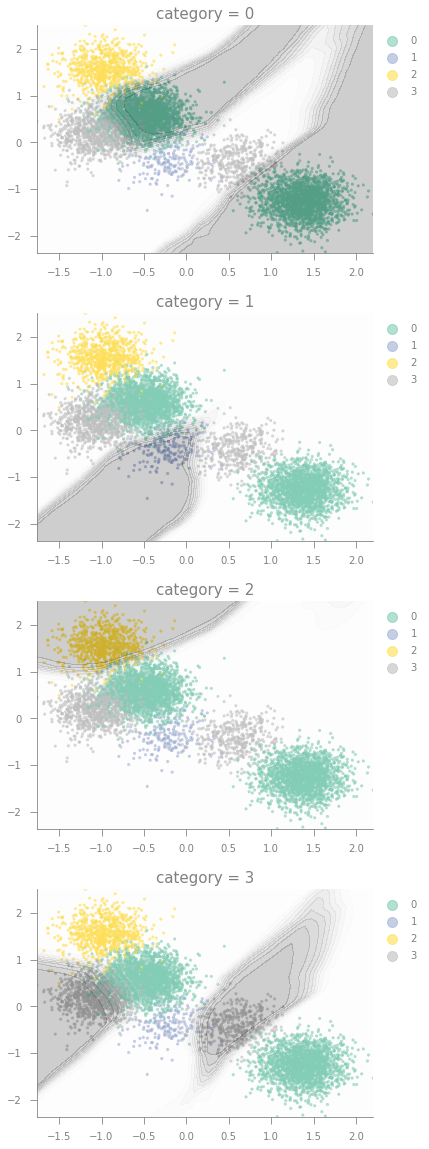

In [169]:
def plot_prediction_grid(model, 
                         X, y, 
                         n, 
                         cmap = 'Set2') -> None:
    
    categories = y_ordinal_encoder.categories_[0]
    n_categories = len(categories)
    
    X = X_standard_scaler.transform(X)
    y = y_ordinal_encoder.transform(y[:, None]).squeeze()
    
    def generate_grids(X, n):
        space_range = zip(
            np.min(X, axis = 0).tolist(), 
            np.max(X, axis = 0).tolist()
        )
        space = list(map(
            lambda x: np.linspace(*x, num = n), space_range
        ))
        meshgrid = np.meshgrid(*space)
        grid_flat = np.column_stack(
            list(map(lambda x: np.ravel(x), meshgrid))
        )   
        return meshgrid, grid_flat

    meshgrid, grid_flat = generate_grids(X, n)
    
    grid_tensor = grid_flat.astype(params['dtypes']['X'])
    grid_tensor = (
        torch.from_numpy(grid_tensor)
        .to(params['device'])
    )
    
    model.eval() 
    with torch.autograd.inference_mode(mode=True):
        grid_flat_pred = (
            model(grid_tensor)
            .softmax(1)
            .to(device = 'cpu')
        )

    
    fig, ax = plt.subplots(
        n_categories, 1, 
        figsize = (6, n_categories * 4), 
        constrained_layout = True
    )
    
    for i, category in enumerate(categories):
        category_prob = (
            grid_flat_pred[:, i]
            .reshape(meshgrid[0].shape)
        )
        
        p = ax[i].scatter(
            *X.T, 
            c=y, 
            alpha = 0.5,
            cmap=cmap, 
            s=5
        )
        _ = ax[i].legend(
            *p.legend_elements(prop='colors', size=10),
            bbox_to_anchor=(1,1)
        )
        _ = ax[i].contourf(
            *meshgrid, 
            category_prob, 
            alpha = 0.2, 
            cmap = 'Greys', 
            levels = 10
        )
        ax[i].set_title(f'category = {i}')

plot_prediction_grid(blobs_classifier, X_train, y_train, 50)

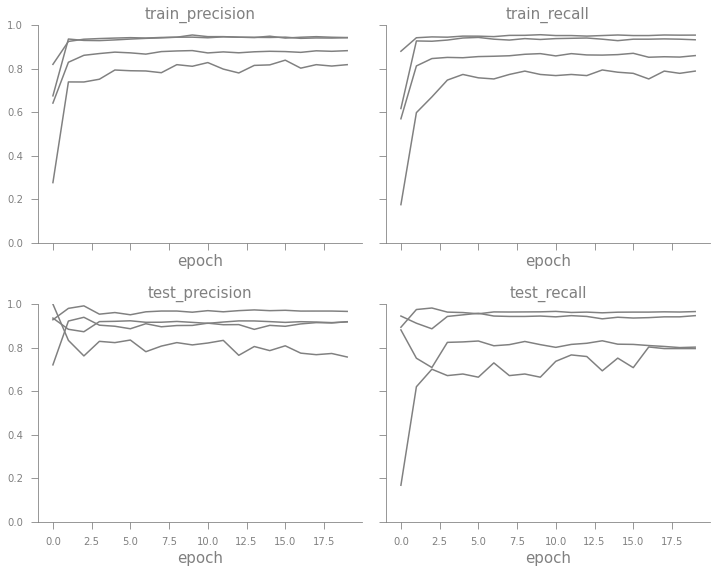

In [170]:
def plot_training_stats(model) -> None:
    # dictionaries with the indices for the plotting axes
    stats = {'precision': 0, 'recall': 1}
    datasets = {'train': 0, 'test': 1}
    
    fig, ax = plt.subplots(
        2, 2, 
        figsize = (10, 8),
        constrained_layout = True, 
        sharex = True, sharey = True
    )
    
    for stat, j in stats.items():
        for dataset, i in datasets.items():
            stat_name = dataset + '_' + stat
            stat_ = model.stats[stat_name]
            x = np.arange(stat_.shape[0])

            ax[i, j].plot(x, stat_, c = 'grey')
            ax[i, j].set_title(stat_name)
            ax[i, j].set_xlabel('epoch')
            ax[i, j].set_ylim(0, 1)
    
plot_training_stats(blobs_classifier)